# Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold


# Data Preparation

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
df.shape

(1319, 12)

In [4]:
df['card'] = (df.card == 'yes').astype(int)

# card_values = {
#     "yes": 1,
#     "no": 0
# }
# data["card"] = data.card.map(card_values)
# data.head(10)

In [5]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card
y_val = df_val.card
y_test = df_test.card

del df_train['card']
del df_val['card']
del df_test['card']

# Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.
- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g -df_train['expenditure'])


Which numerical variable (among the following 4) has the highest AUC?
- reports
- dependents
- active
- share

In [7]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]
categorical = ["owner", "selfemp"]

In [8]:
for i in numerical:
    auc = roc_auc_score(df_full_train.card, df_full_train[i])
    if auc < 0.5:
        auc = roc_auc_score(df_full_train.card, -df_full_train[i])
    print(i, auc.round(4))

reports 0.7162
age 0.5044
income 0.5841
share 0.9882
expenditure 0.9891
dependents 0.5179
months 0.5208
majorcards 0.5409
active 0.5913


In [9]:
# Answer is share

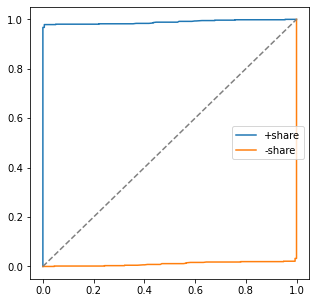

In [10]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.share)
plt.plot(fpr, tpr, label='+share')

fpr, tpr, _ = roc_curve(y_train, -df_train.share)
plt.plot(fpr, tpr, label='-share')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

# Training the Model

In [11]:
base = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", 
        "active", "owner", "selfemp"]

columns = base

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

# Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.615
- 0.515
- 0.715
- 0.995

In [12]:
val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

roc_auc_score(y_val,  y_pred).round(3)

0.995

In [13]:
# Answer is 0.995

# Question 3
Compute precision and recall for our model
- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which treshold precision and recall curves intersect?
- 0.1
- 0.3
- 0.6
-0.8

In [45]:
thresholds = np.linspace(0, 1 ,101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (actual_positive & predict_positive).sum()
    fp = (actual_negative & predict_positive).sum()
    
    tn = (actual_negative & predict_negative).sum()
    fn = (actual_positive & predict_negative).sum()
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    scores.append([t, precision, recall])

In [46]:
scores = pd.DataFrame(scores, columns = ['threshold', 'precision', 'recall'])

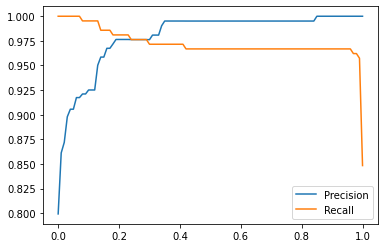

In [49]:
plt.plot(scores.threshold, scores.precision, label='Precision')
plt.plot(scores.threshold, scores.recall, label='Recall')
plt.legend()

In [50]:
scores[scores.precision == scores.recall]

,threshold,precision,recall
24,0.24,0.976303,0.976303
25,0.25,0.976303,0.976303
26,0.26,0.976303,0.976303
27,0.27,0.976303,0.976303
28,0.28,0.976303,0.976303
29,0.29,0.976303,0.976303


In [ ]:
# Answer is ~0.3

# Question 4
Precision and Recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: 
    <br>$F_{1} = 2 . \frac{P.R}{P+R}$
    
Where P is precision and R is recall.

Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set.

At which threshold F1 is maximal?
- 0.1
- 0.4
- 0.6
- 0.7


In [51]:
thresholds = np.linspace(0, 1, 101)

In [52]:
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actuaL_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f1 = 2*((precision*recall)/(precision+recall))
    
    scores.append([t,f1])
    
scores = pd.DataFrame(scores, columns = ['threshold', 'f1-score'])

In [56]:
scores[scores['f1-score'] == scores['f1-score'].max()]

,threshold,f1-score
35,0.35,0.983213
36,0.36,0.983213
37,0.37,0.983213
38,0.38,0.983213
39,0.39,0.983213
40,0.40,0.983213
41,0.41,0.983213


In [ ]:
# Answer is ~0.4

# Question 5
Use the **KFold** class from Scikit-Learn to evaluate our model on 5 different folds:
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the AUC scores across different folds?
- 0.003
- 0.014
- 0.09
- 0.24

In [58]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]
categorical = ["owner", "selfemp"]

In [59]:
def train(df,y_train, C=1):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [60]:
def predict(df,dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [62]:
from tqdm.auto import tqdm

In [66]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=5):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

  0%|          | 0/5 [00:00<?, ?it/s]

In [69]:
np.array(scores).std().round(3)

0.003

In [ ]:
# Answer is 0.003

# Question 6
Let's use 5-Fold cross-validation to find the best parameter C
- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?
- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [70]:
def train(df,y_train, C=1):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [73]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in tqdm([0.01, 0.1, 1, 10]):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train,C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C:", C,"score:", np.mean(scores).round(3), "+-", np.std(scores).round(3))

  0%|          | 0/4 [00:00<?, ?it/s]

C: 0.01 score: 0.992 +- 0.006
C: 0.1 score: 0.995 +- 0.004
C: 1 score: 0.996 +- 0.003
C: 10 score: 0.996 +- 0.003


In [ ]:
# Answer is 1